url: https://www.naver.com/, MIME Type: text/html, Size: 389 bytes
url: https://ssl.pstatic.net/sstatic/search/pc/css/sp_autocomplete_240725.css, MIME Type: text/css, Size: 1310 bytes
url: https://ssl.pstatic.net/tveta/libs/ndpsdk/prod/ndp-loader.js, MIME Type: application/javascript, Size: 850 bytes
url: https://pm.pstatic.net/resources/css/main.6efa9308.css, MIME Type: text/css, Size: 8577 bytes
url: https://ssl.pstatic.net/tveta/libs/glad/prod/gfp-core.js, MIME Type: application/javascript, Size: 1287 bytes
url: https://ssl.pstatic.net/tveta/libs/assets/js/pc/main/min/pc.veta.core.min.js, MIME Type: application/javascript, Size: 8544 bytes
url: https://pm.pstatic.net/resources/js/search.390983ad.js?o=www, MIME Type: application/javascript, Size: 2859 bytes
url: https://pm.pstatic.net/resources/js/preload.c6b0ed48.js?o=www, MIME Type: application/javascript, Size: 14233 bytes
url: https://ssl.pstatic.net/tveta/libs/ndpsdk/prod/ndp-core.js, MIME Type: application/javascript, Size: 128
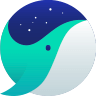
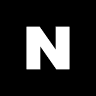

In [2]:
import chromedriver_autoinstaller
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import json
import time
# 크롬 드라이버 자동 설치
chromedriver_autoinstaller.install()

# 크롬 옵션 설정
options = Options()
options.set_capability('goog:loggingPrefs', {'performance': 'ALL'})
options.add_argument('--headless')  # 브라우저를 표시하지 않고 실행
options.add_argument('--disable-web-security')  # CORS 정책 우회 설정
options.add_argument('--ignore-certificate-errors')  # SSL 인증서 무시 설정

# 드라이버 초기화
driver = webdriver.Chrome(options=options)

# 네트워크 로그 수집
driver.get('https://naver.com')  # 대상 웹사이트로 변경

resource_types = {'Document': 0, 'Stylesheet': 0, 'Script': 0, 'Image': 0, 'Media': 0, 'Other': 0}
total_size = 0

for log in driver.get_log('performance'):
    message = json.loads(log["message"])["message"]
    if "Network.responseReceived" == message["method"]: # event는 log에 method로 기록되어있음
        mime_type = message['params']['response']['mimeType'] # MIME 타입
        resource_size = message['params']['response']['encodedDataLength'] # encodedDataLength로 리소스 사이즈 가져오기
        url = message['params']['response']['url']

        # MIME 타입에 따라 resource_size 리소스 유형을 분류 및 합산
        if 'text/html' in mime_type:
            resource_types['Document'] += resource_size
        elif 'text/css' in mime_type:
            resource_types['Stylesheet'] += resource_size
        elif 'application/javascript' in mime_type or 'application/x-javascript' in mime_type or 'text/javascript' in mime_type:
            resource_types['Script'] += resource_size
        elif 'image' in mime_type or ('application/octet-stream' in mime_type and ('.png' in url or '.jpg' in url or '.jpeg' in url or '.gif' in url)):  # 추가 조건
            resource_types['Image'] += resource_size
        elif 'video' in mime_type or 'audio' in mime_type:
            resource_types['Media'] += resource_size
        else:
            resource_types['Other'] += resource_size
        time.sleep(0.1)
        total_size += resource_size
        print(f"url: {url}, MIME Type: {mime_type}, Size: {resource_size} bytes")

# 드라이버 종료
driver.quit()

# 결과 출력
print("Resource Sizes:")
for resource_type, size in resource_types.items():
    print(f"{resource_type}: {size} bytes")

print(f"Total Network Size: {total_size} bytes")

# 탄소 배출량 추정 (1GB = 0.06kg CO2)
total_size_gb = total_size / (1024 ** 3)
carbon_emission = total_size_gb * 0.06
print(f"Estimated Carbon Emission: {carbon_emission:.6f} kg CO2")


# 하위 도메인 크롤링 
# 

In [2]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.parse import urljoin, urlparse
import re

# 이미 방문한 페이지들을 저장하기 위한 집합
pages = set()

def getLinks(domain, pageUrl):
    global pages
    # URL을 조합하여 절대 URL을 만듦
    full_url = urljoin("http://" + domain, pageUrl)
    
    try:
        html = urlopen(full_url)
    except Exception as e:
        print(f"Error opening {full_url}: {e}")
        return

    bs = BeautifulSoup(html, "html.parser")
    # 모든 a 태그에서 링크를 찾음
    for link in bs.find_all("a", href=True):
        href = link.attrs['href']
        # 절대 URL로 변환
        href = urljoin(full_url, href)
        # URL을 파싱하여 도메인 검사
        parsed_href = urlparse(href)
        if domain in parsed_href.netloc and href not in pages:
            print(href)
            pages.add(href)
            # 새로운 페이지로 재귀 호출
            getLinks(domain, parsed_href.path)

getLinks("naver.com", "")
print("pages", pages)


http://naver.com#topAsideButton
http://naver.com#shortcutArea
http://naver.com#newsstand
http://naver.com#shopping
http://naver.com#feed
http://naver.com#account
http://naver.com#widgetboard
http://naver.com#viewSetting
pages {'http://naver.com#widgetboard', 'http://naver.com#topAsideButton', 'http://naver.com#shortcutArea', 'http://naver.com#newsstand', 'http://naver.com#shopping', 'http://naver.com#viewSetting', 'http://naver.com#feed', 'http://naver.com#account'}


# Sub-domain 크롤링

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import chromedriver_autoinstaller

# 크롬 드라이버 자동 설치
chromedriver_autoinstaller.install()

# 크롬 옵션 설정
options = Options()
options.set_capability('goog:loggingPrefs', {'performance': 'ALL'})
options.add_argument('--headless')  # 브라우저를 표시하지 않고 실행
options.add_argument('--disable-web-security')  # CORS 정책 우회 설정
options.add_argument('--ignore-certificate-errors')  # SSL 인증서 무시 설정

# 크롬 드라이버 설정
driver = webdriver.Chrome(options=options)
pages = set()

def getAllLinks(url):
    global pages
    # 주어진 URL로 이동
    driver.get(url)
    # 페이지 소스를 가져와서 BeautifulSoup으로 파싱
    html = driver.page_source
    bs = BeautifulSoup(html, "html.parser")

    # 모든 a 태그에서 링크를 찾음
    for link in bs.find_all("a", href=True):
        href = link.attrs['href']
        # 절대 URL로 변환
        href = urljoin(url, href)
        if href not in pages:
            pages.add(href)
            print(href)

getAllLinks("http://www.naver.com")
print("pages", pages)

# 드라이버 종료
driver.quit()


http://www.naver.com#topAsideButton
http://www.naver.com#shortcutArea
http://www.naver.com#newsstand
http://www.naver.com#shopping
http://www.naver.com#feed
http://www.naver.com#account
http://www.naver.com#widgetboard
http://www.naver.com#viewSetting
http://www.naver.com/
http://www.naver.com
https://help.naver.com/alias/search/word/word_35.naver
https://help.naver.com/support/alias/search/word/word_35.naver
https://help.naver.com/alias/search/word/word_16.naver
https://nid.naver.com/nidlogin.login
https://help.naver.com/alias/search/word/word_17.naver
https://help.naver.com/alias/search/word/word_18.naver
https://siape.veta.naver.com/rd?rk=zrCEIMoYLxPdpDRKQ2zpWA&eltts=KkiWMGs5D7gErSqCGHQ7Pw%3D%3D&elu=44024063BE5902452D66E0057AAEBFE3301A5D8179915914E4B13EFFDDAB44754C01367111827845CF04E00927369C40294E7AC7BC76E89F17B3BB9F5FC0C826DE9C9F59E56EDA85967F7C59D208E506788362A4F9E9EA4673A1BDA50BA100D00074BEAD261EC6B9ABDACAFE7EAFEBA8C3A6206533A4565309044A81E49577D490B450E69492C414244A799F69744862

# Sub-domain 타고 들어가서 재귀로 크롤링 하기
- 1) 재귀함수로 (subdomain이 없을때 까지 진행하면서 pages set에 저장합니다.)
- 2) pages set에 저장된 url을 

http://www.naver.com#topAsideButton
http://www.naver.com#shortcutArea
http://www.naver.com#newsstand
http://www.naver.com#shopping
http://www.naver.com#feed
http://www.naver.com#account
http://www.naver.com#widgetboard
http://www.naver.com#viewSetting
http://www.naver.com/
http://www.naver.com/#topAsideButton
http://www.naver.com/#shortcutArea
http://www.naver.com/#newsstand
http://www.naver.com/#shopping
http://www.naver.com/#feed
http://www.naver.com/#account
http://www.naver.com/#widgetboard
http://www.naver.com/#viewSetting
https://help.naver.com/alias/search/word/word_35.naver
https://www.naver.com
https://www.naver.com#topAsideButton
https://www.naver.com#shortcutArea
https://www.naver.com#newsstand
https://www.naver.com#shopping
https://www.naver.com#feed
https://www.naver.com#account
https://www.naver.com#widgetboard
https://www.naver.com#viewSetting
https://www.naver.com/
https://www.naver.com/#topAsideButton
https://www.naver.com/#shortcutArea
https://www.naver.com/#newsstand

WebDriverException: Message: unknown error: unsupported protocol
  (Session info: chrome-headless-shell=127.0.6533.74)
Stacktrace:
	GetHandleVerifier [0x00928923+23283]
	(No symbol) [0x008EE934]
	(No symbol) [0x00820733]
	(No symbol) [0x00823072]
	(No symbol) [0x0089D4D7]
	(No symbol) [0x0088441C]
	(No symbol) [0x0089CB8D]
	(No symbol) [0x008841B6]
	(No symbol) [0x00858017]
	(No symbol) [0x0085890D]
	GetHandleVerifier [0x00A1A5F3+1013699]
	GetHandleVerifier [0x00A23E4C+1052700]
	GetHandleVerifier [0x00A1D4B4+1025668]
	GetHandleVerifier [0x0094EA2B+179195]
	(No symbol) [0x008F6833]
	(No symbol) [0x008F3198]
	(No symbol) [0x008F3337]
	(No symbol) [0x008EB4BE]
	BaseThreadInitThunk [0x75A47BA9+25]
	RtlInitializeExceptionChain [0x7767C10B+107]
	RtlClearBits [0x7767C08F+191]


# 타고 들어간 내용 remote Database에 저장하기 

OSError: [WinError 193] %1은(는) 올바른 Win32 응용 프로그램이 아닙니다